# CPredictive Modeling of Power Plant Energy Output: A Comprehensive Analysis Using Linear and KNN Regression

<h5>The project "Predictive Modeling of Power Plant Energy Output" presents an in-depth analysis of the Combined Cycle Power Plant Data Set, spanning from 2006 to 2011. This study aims to predict the net hourly electrical energy output (EP) using ambient variables like Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V). The project encompasses various statistical and machine learning techniques, including linear regression, multiple regression, and k-nearest neighbor (KNN) regression, to establish relationships between predictors and the power plant’s energy output.</h5>

## 1. Combined Cycle Power Plant Data Set

### Download Data

Package imports

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances
import math
from math import sqrt, floor
  

import warnings
warnings.filterwarnings("ignore")

Get the Cycle Power Plant Data Set

In [2]:
df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx');
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


### Exploring the data

#### rows and columns

In [3]:
num_row = len(df)
num_col = len(df.columns)
print(f"Number of rows: {num_row}")
print(f"Number of columns: {num_col}")

Number of rows: 9568
Number of columns: 5


The rows represent individual samples or data points, each with a unique combination of features.
The columns represent the features or variables that describe each data point-- AT, V, AP, RH, and PE.

#### pairwise scatterplots of all the varianbles

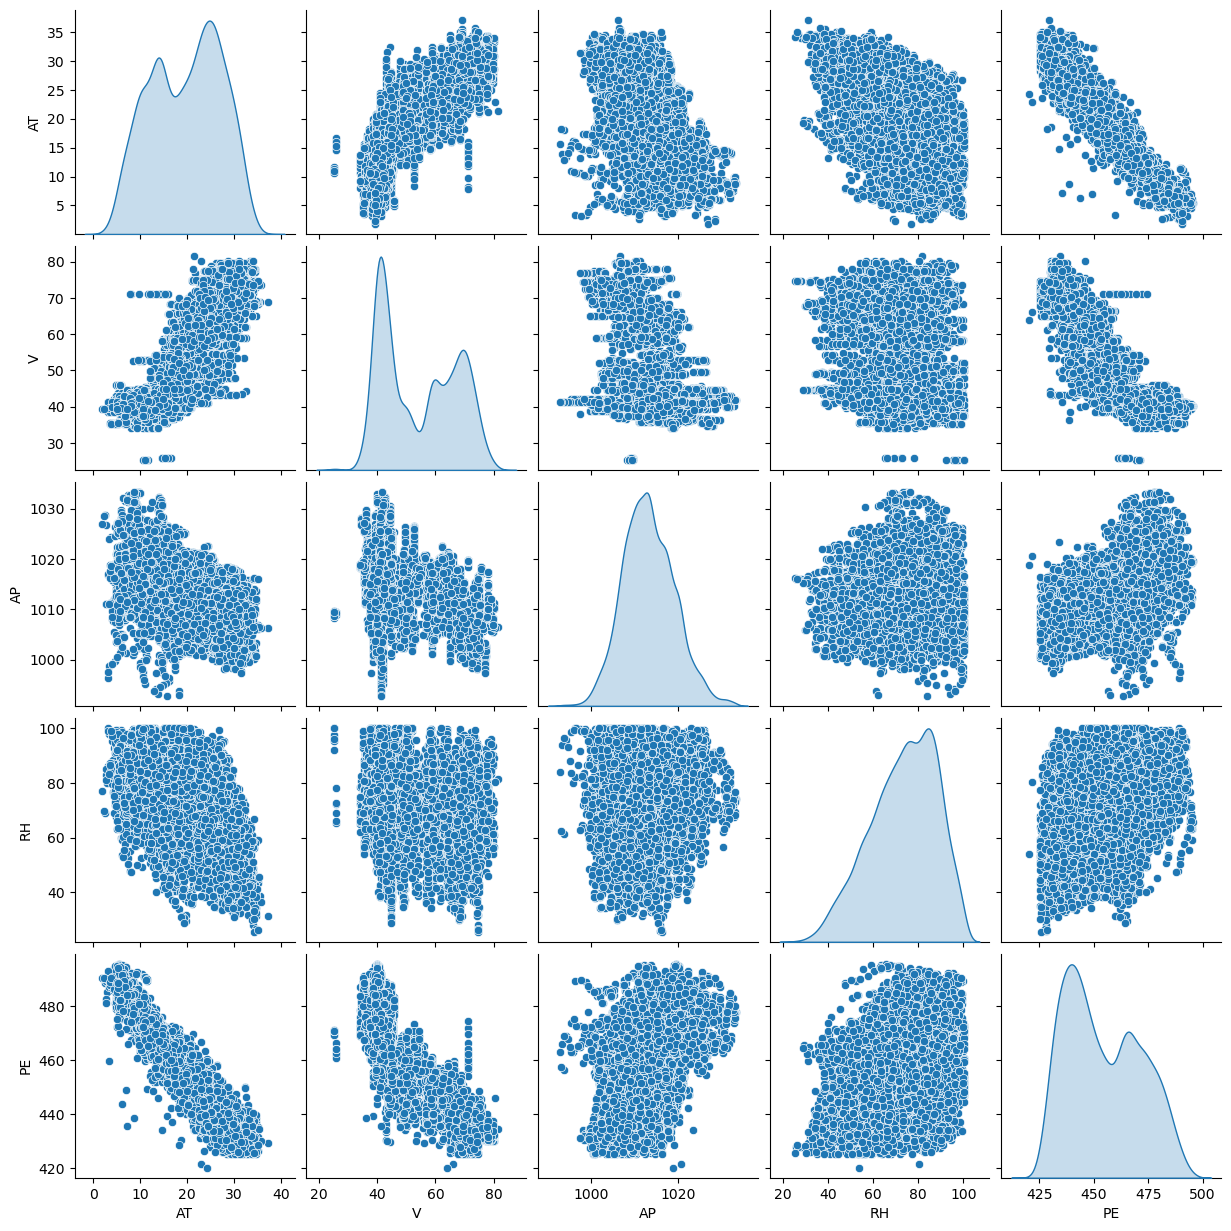

In [4]:
pairscatter_plot = sns.pairplot(df, diag_kind="kde")

plt.show()

#### mean, the median, range, first and third quartiles, and interquartile ranges

In [5]:
# Create dataframe 
stats = pd.DataFrame(index=['mean', 'median', 'range', 'q1', 'q3', 'iqr'])

# Loop through and calculate stats 
for col in df.columns:
  
    mean = df[col].mean()
    median = df[col].median()
    range = df[col].max() - df[col].min() 
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    stats[col] = [mean, median, range, q1, q3, iqr]

# Display summary table  
print(stats.round(1))

          AT     V      AP    RH     PE
mean    19.7  54.3  1013.3  73.3  454.4
median  20.3  52.1  1012.9  75.0  451.6
range   35.3  56.2    40.4  74.6   75.5
q1      13.5  41.7  1009.1  63.3  439.8
q3      25.7  66.5  1017.3  84.8  468.4
iqr     12.2  24.8     8.2  21.5   28.7


### Simple Linear Regression

my assertions: there is a statistically significant association for all of them

In [6]:
# get the datasets separately
AT_train = df['AT']
V_train = df['V']
AP_train = df['AP']
RH_train = df['RH']
PE_train = df['PE']
# generate a coefficient dictionary that holds the regression coefficients
coefficients = {}

# define a fitRegressionModel function
# Function: fitRegressionModel
# Parameters: independent training set and dependent training set
# Side-effect: Output the scatterplot, the boxplot, and the regression results.
def fitRegressionModel(x_training, y_training, var_name):
    
    # get the training set and get the predicts
    x_train = sm.add_constant(x_training, prepend=False)
    # Fit and summarize OLS model
    mod = sm.OLS(y_training, x_train)
    res = mod.fit()
    y_predicts = res.predict(x_train)
    
    # find index of x train if it is an outlier
    outliers = res.outlier_test()
    outl_index = []
    # get the p-vals for the outliers
    p_vals = outliers.loc[:,"bonf(p)"]
    index = 0
    # treat the datapoint as an outlier if the corrected p val is less than the threshold 0.05
    for i in p_vals:
        if i < 0.05:
            outl_index.append(index)
        index += 1

    # print out the results
    print(res.summary())

    # plot the scatterplot
    plt.figure(figsize=(10,6))
    plt.scatter(x_training, y_training)
    # plot the outliers
    plt.scatter(x_training[outl_index], y_training[outl_index], marker="x", label="Outliers")
    # plot the regressionline
    plt.plot(x_training, y_predicts, "tab:orange", label="Rgression Result")
    plt.title("Simple Linear Regression for {}".format(var_name))
    plt.xlabel(var_name)
    plt.ylabel("PE")
    plt.legend()
    plt.show()
    
    # print outliers:
    if outl_index:
        outl_summary = pd.DataFrame({"{}".format(var_name): x_training[outl_index],
                            "PE":y_training[outl_index]})
        print("\nOutliers are shown in the table below:")
        print(outl_summary.reset_index().drop(columns = "index")) 
    else:
        print("There is no outlier.")
    
    # record coefficients of the model into the dictionary
    coefficients[var_name] = res.params[0]

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:32:30   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -2.1713      0.007   -291.715      0.0

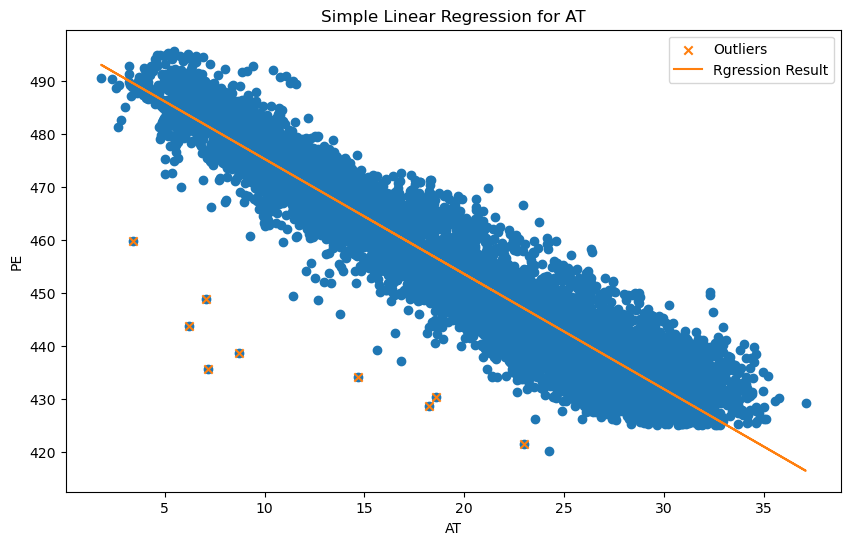


Outliers are shown in the table below:
      AT      PE
0   8.74  438.63
1   6.22  443.73
2  14.69  434.12
3  23.00  421.57
4  18.60  430.38
5   7.06  448.97
6   7.14  435.58
7  18.26  428.67
8   3.40  459.86


In [7]:
fitRegressionModel(AT_train, PE_train, "AT")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:32:52   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
V             -1.1681      0.007   -172.402      0.0

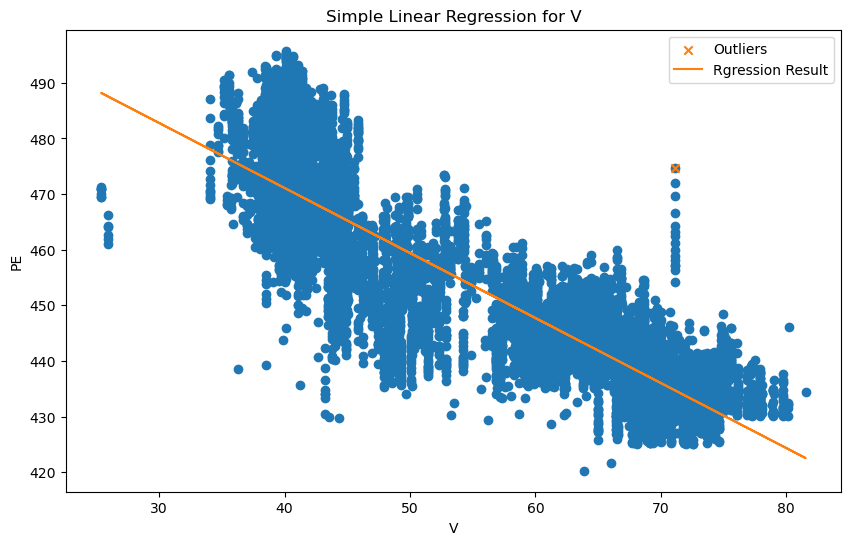


Outliers are shown in the table below:
       V      PE
0  71.14  474.66


In [8]:
fitRegressionModel(V_train, PE_train, "V")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:33:14   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AP             1.4899      0.025     59.296      0.0

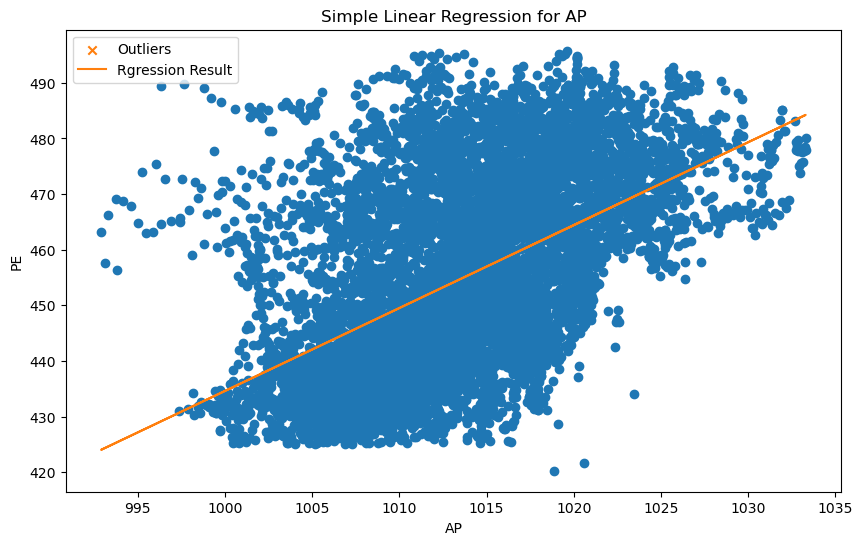

There is no outlier.


In [9]:
fitRegressionModel(AP_train, PE_train, "AP")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:33:38   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RH             0.4557      0.011     41.399      0.0

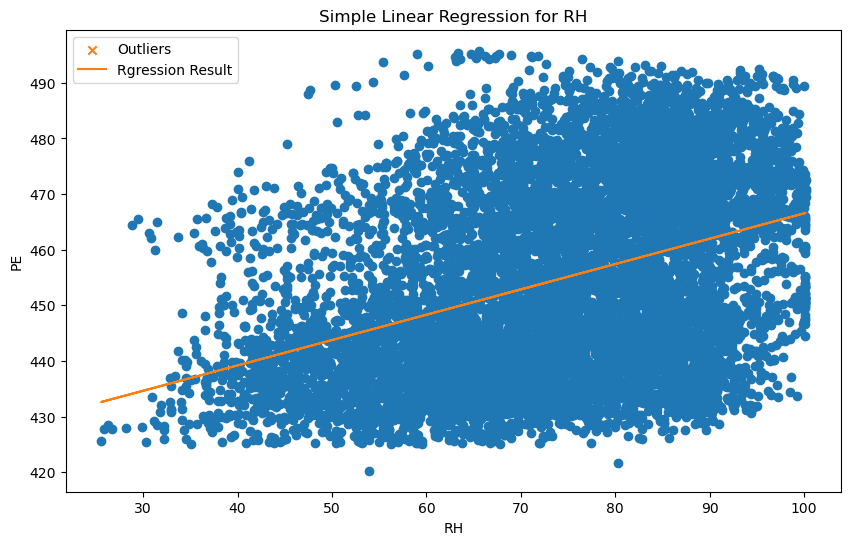

There is no outlier.


In [10]:
fitRegressionModel(RH_train, PE_train, "RH")

In [11]:
coefficients

{'AT': -2.171319958517797,
 'V': -1.168135126555736,
 'AP': 1.4898716733991177,
 'RH': 0.4556501022629851}

### Multiple Regression

In [13]:
# multiple regression model training feature dataset
x_train_multi = df.iloc[:,:-1]
# get the training set and get the predicts
x_train = sm.add_constant(x_train_multi, prepend=False)
# Fit and summarize OLS model
mod = sm.OLS(PE_train, x_train)
res = mod.fit()
y_predicts = res.predict(x_train)
# print out the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:35:25   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -1.9775      0.015   -129.342      0.0

The p-values for AT, V, AP, and RH are all 0.000, which is below the standard 0.05 significance level.

Therefore, for these four predictors, I can reject the null hypothesis that the coefficient is equal to 0 (H0: βj = 0).

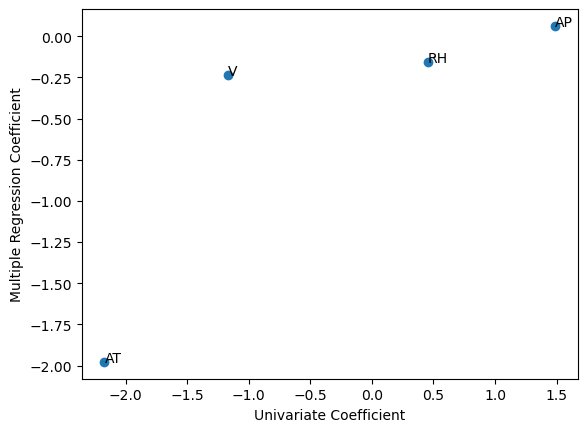

In [14]:
# univariate regression coefficients
uni_coef = coefficients

# multi regression coefficients
multi = res.params
multi_coef = multi.to_dict()

# get common keys
keys = uni_coef.keys() & multi_coef.keys()

# get values for common keys 
x = [uni_coef[key] for key in keys]
y = [multi_coef[key] for key in keys]

# create scatter plot 
plt.scatter(x, y)
# plt.scatter(list(uni_coef.values()), list(multi_coef.values()))

# # add variable labels
for var in keys:
    plt.text(uni_coef[var], multi_coef[var], var)

# Add axis labels
plt.xlabel('Univariate Coefficient')
plt.ylabel('Multiple Regression Coefficient')

plt.show()

### Nonlinear Association

In [15]:
for predictor in ['AT', 'V', 'AP', 'RH']:

    # Generate polynomial features 
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(df[[predictor]])

    # Fit polynomial regression model
    model = sm.OLS(df['PE'], X_poly)
    
    res_poly = model.fit()

    # Check if higher degree coefficients are significant
    print("Preidctor:",predictor)
    print(res_poly.summary())

Preidctor: AT
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:35:37   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    73

AT:
The quadratic and cubic terms are statistically significant, indicating a nonlinear relationship between AT and PE.

V:
Only the cubic term is marginally significant, with minimal evidence of nonlinearity.

AP:
The quadratic and cubic terms are significant, suggesting a nonlinear association.

RH:
The quadratic and cubic terms are significant, suggesting a nonlinear association.

### Interactions of Predictors

In [16]:
# Create formula with all interactions
formula = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'

# Fit model
model = smf.ols(formula=formula, data=df).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:35:39   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

There are statistically significant interaction effects between:
    AT and V
    AT and RH
    V and AP
    AP and RH
since they each has a p-value that is smaller than 0.05

### Improvement

In [17]:
# split data into 70% train and 30% test sets
train_size = floor(len(df)*0.7)
train, test= train_test_split(df, train_size=train_size, random_state=3456, shuffle=True)

X_train = train.iloc[:,:-1]
y_train = train.iloc[:, -1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:, -1]

In [18]:
mse = {}

# a generative model
def improved_model(formula, train_set, X_train, y_train, X_test, y_test, model):
    mod = smf.ols(formula, train_set)
    res = mod.fit()
    
    # get the predicted results
    y_train_predict = res.predict(X_train)
    y_test_predict = res.predict(X_test)
    
    # display the summary
    print(res.summary())
    
    # display the MSE
    train_MSE = mean_squared_error(y_train_predict, y_train)
    test_MSE = mean_squared_error(y_test_predict, y_test)
    print("\nThe train MSE is", train_MSE, ", and the test MSE is", test_MSE)
    # store the MSE
    mse[model] = [train_MSE, test_MSE]

In [19]:
improved_model('PE ~ AT + V + AP + RH', train, X_train, y_train, X_test, y_test, "Baseline Linear Regression")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.201e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:35:41   Log-Likelihood:                -19621.
No. Observations:                6697   AIC:                         3.925e+04
Df Residuals:                    6692   BIC:                         3.929e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    450.8311     11.623     38.789      0.0

In [20]:
improved_model('PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT:V + AT:RH + V:AP + AP:RH', train, X_train, y_train, X_test, y_test, "Improved Linear Regression")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     9260.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:35:41   Log-Likelihood:                -19162.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6685   BIC:                         3.843e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -7630.8613   1236.230     

In [21]:
rg_mse_df = pd.DataFrame(mse)
rg_mse_df.index = ['Train MSE', 'Test MSE'] 
print(rg_mse_df.to_string())

           Baseline Linear Regression  Improved Linear Regression
Train MSE                   20.528258                   17.899445
Test MSE                    21.334393                   18.632127


### KNN

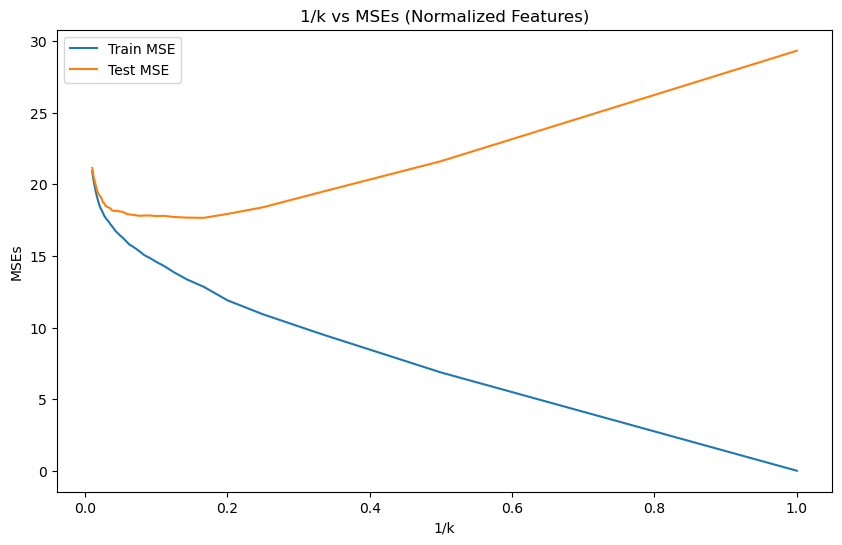


The optimal k is 5 with a minimum test MSE 17.661842890591732  for normalized features.


In [34]:
# PART1: normalized features
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)

# fit the model
normalized_k_list = []
# obtain training/testing error
normalized_train_MSE_list = []
normalized_test_MSE_list = []

# empty MSE dictionary 
MSEs = {}

# k for k ∈ {1,2,...,100}
k_values = np.arange(1, 101).tolist()
for i in k_values:
    normalized_k_list.append(1/i)
    
    # train and fit the model
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_normalized,y_train)
    
    # training predictions and MSE and append the MSE to the training MSE list
    y_train_predict_normalized = knn.predict(X_train_normalized)
    normalized_train_MSE_list.append(mean_squared_error(y_train, y_train_predict_normalized))
    # testing predictions and MSE and append the MSE to the testing MSE list
    y_test_predict_normalized = knn.predict(X_test_normalized)
    normalized_test_MSE_list.append(mean_squared_error(y_test, y_test_predict_normalized))
    
    # store the MSE
    MSEs["Normalized_KNN"] = [min(normalized_train_MSE_list), min(normalized_test_MSE_list)]

# plot 1/k vs. MSEs
plt.figure(figsize=(10,6))
plt.plot(normalized_k_list, normalized_train_MSE_list, label="Train MSE")
plt.plot(normalized_k_list, normalized_test_MSE_list, label="Test MSE")
plt.xlabel("1/k")
plt.ylabel("MSEs")
plt.legend()
plt.title("1/k vs MSEs ({})".format("Normalized Features"))
plt.show()


# locate the optimal k with the minimum test MSE
min_test_MSE_nor = min(normalized_test_MSE_list)
optimal_k = normalized_test_MSE_list.index(min_test_MSE_nor)
print("\nThe optimal k is", optimal_k, "with a minimum test MSE", min_test_MSE_nor, " for normalized features.")


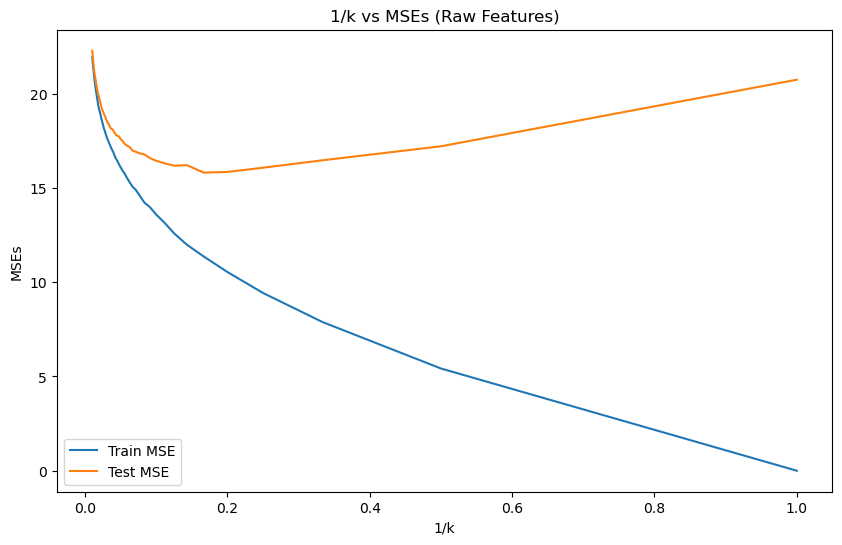


The optimal k is 5 with a minimum test MSE 15.811312285692168  for normalized features.


In [35]:
# PART2: raw features

# fit the model
raw_k_list = []
# obtain training/testing error
raw_train_MSE_list = []
raw_test_MSE_list = []

# k for k ∈ {1,2,...,100}
# k_values = np.arange(1, 101).tolist()
for i in k_values:
    raw_k_list.append(1/i)
    
    # train and fit the model
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    
    # training predictions and MSE and append the MSE to the training MSE list
    y_train_predict_raw = knn.predict(X_train)
    raw_train_MSE_list.append(mean_squared_error(y_train, y_train_predict_raw))
    # testing predictions and MSE and append the MSE to the testing MSE list
    y_test_predict_raw = knn.predict(X_test)
    raw_test_MSE_list.append(mean_squared_error(y_test, y_test_predict_raw))
    
    # store the MSE
    MSEs["Raw_KNN"] = [min(raw_train_MSE_list), min(raw_test_MSE_list)]

# plot 1/k vs. MSEs
plt.figure(figsize=(10,6))
plt.plot(raw_k_list, raw_train_MSE_list, label="Train MSE")
plt.plot(raw_k_list, raw_test_MSE_list, label="Test MSE")
plt.xlabel("1/k")
plt.ylabel("MSEs")
plt.legend()
plt.title("1/k vs MSEs ({})".format("Raw Features"))
plt.show()


# locate the optimal k with the minimum test MSE
min_test_MSE_raw = min(raw_test_MSE_list)
optimal_k_raw= raw_test_MSE_list.index(min_test_MSE_raw)
print("\nThe optimal k is", optimal_k_raw, "with a minimum test MSE", min_test_MSE_raw, " for normalized features.")


### Compare KNN and Linear Regression

In [42]:
# KNN test MSE table
KNN_MSE_table = pd.DataFrame(MSEs)
KNN_MSE_table.index = ["Train MSE", "Test MSE"]
KNN_MSE_table

,Normalized_KNN,Raw_KNN
Train MSE,0.000000,0.000000
Test MSE,17.661843,15.811312


In [41]:
# bring back the linear regression test MSE table for references
rg_mse_df

,Baseline Linear Regression,Improved Linear Regression
Train MSE,20.528258,17.899445
Test MSE,21.334393,18.632127


Analysis: KNN models with both normalized and raw features have a smaller test RSE than the optimal test MSE of the improved Linear Regression model. 

Linear models assume linearity between the predictors and response. But KNN is a nonparametric approach that can learn nonlinear patterns. And since we have proved non-linear patterns between the features and target, KNN would expect to perform better with this question. In addition, there exist interactions between variables, which make them hard to capture by linearity but easier for KNN, as KNN provides a more flexible description of the data.